In [1]:
import torch
import torch.nn as nn
from src.utils.flow import LinearFlow, FlowSimulator, GaussianFlow
from src.utils.trainer import IsingTrainer
from architecture.nn_models import IsingNet, TinyField
from src.utils.dataset import GlobalFlipSampler, GaussianBaseSampler, GlobalUpSampler, IsingSampler
from matplotlib import pyplot as plt
import torch.nn.functional as F
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Path to training data (adjust as needed)
h5path = "../../data/gridstates_0.588_0.100.hdf5"

Using device: cuda


In [3]:
# Create samplers
sampler = IsingSampler(h5path, device=device)
#sampler = GlobalUpSampler(64, device)
base = GaussianBaseSampler(channels=1, height=64, width=64)

# Create flow and model
flow = GaussianFlow(sampler, base)
model = IsingNet(
    channels=[32],
    time_dim=32,
    num_res_layers=2
).to(device)

#model = TinyField(64, time_dim=2).to(device)

# Create trainer
trainer = IsingTrainer(flow, model)

Loaded 332800 grids and attributes into memory.
Elapsed time: 1.99 s


In [ ]:
# Train the model
print("Starting training...")
loss_history = trainer.train_history(num_epochs=500, device=device, lr=1e-3, batch_size=128)
print("Training completed.")

Starting training...


Epoch 499, loss: 166.21319580078125: 100%|██████████| 500/500 [01:24<00:00,  5.92it/s]

Training completed.


In [ ]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.show()


100%|██████████| 99/99 [00:02<00:00, 41.31it/s]


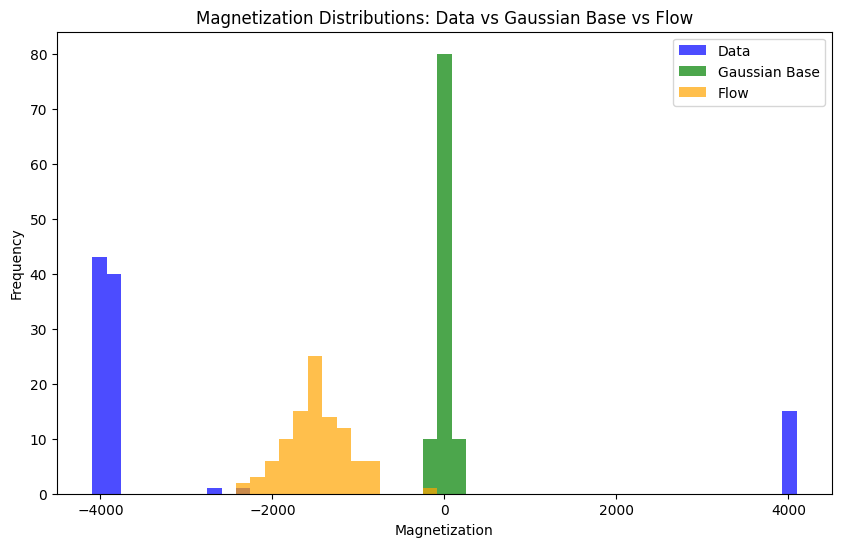

In [5]:
import numpy as np

# Sample from data distribution
num_samples = 100
data_samples, _ = sampler.sample(num_samples, device=device)  # shape (1000, 1, 64, 64)
data_magnetizations = data_samples.sum(dim=[1,2,3]).cpu().numpy()  # sum over channels, height, width

gauss_samples = base.sample(num_samples, device=device)
gauss_magnetizations = gauss_samples.sum(dim=[1,2,3]).cpu().numpy()

# Sample from flow distribution
with torch.no_grad():
    simulator = FlowSimulator(model)
    num_steps = 100
    x_init = base.sample(num_samples, device=device)
    ts = torch.linspace(0,1,num_steps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    flow_samples = simulator.simulate(x_init, ts)  # final samples
    flow_samples = flow_samples.sign()
    flow_magnetizations = flow_samples.sum(dim=[1,2,3]).cpu().numpy()

# Plot histograms on the same graph with same bins
bins = np.linspace(-4096, 4096, 50)  # 64*64=4096, so range from -4096 to 4096

plt.figure(figsize=(10, 6))

plt.hist(data_magnetizations, bins=bins, alpha=0.7, label='Data', color='blue')
plt.hist(gauss_magnetizations, bins=bins, alpha=0.7, label='Gaussian Base', color='green')
plt.hist(flow_magnetizations, bins=bins, alpha=0.7, label='Flow', color='orange')

plt.title('Magnetization Distributions: Data vs Gaussian Base vs Flow')
plt.xlabel('Magnetization')
plt.ylabel('Frequency')
plt.legend()

plt.show()